<a href="https://colab.research.google.com/github/SurajLahariya/DS_learning/blob/main/Assignment_18_Airlines_Data_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import necessary libraries

In [ ]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

## 2. Data collection

In [ ]:
df = pd.read_excel(r'C:\Users\sawaled\Desktop\Personal\data\Assignement_18_Forecasting\Airlines_Data.xlsx')
df.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


#### ========================================================================================================

## 3. Data Understanding, Visulalization and Preaparation 

In [ ]:
df.shape

(96, 2)

In [ ]:
df.isna().sum()

Month         0
Passengers    0
dtype: int64

In [ ]:
df.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

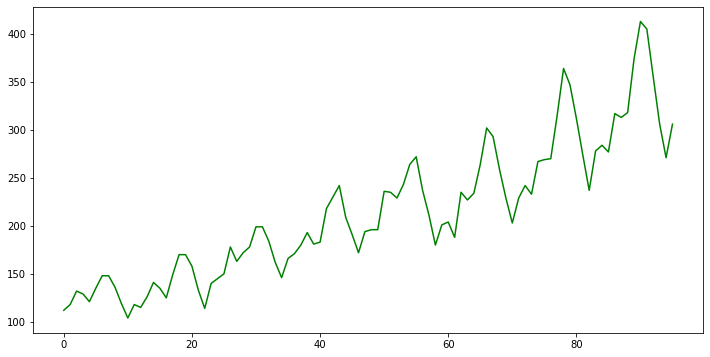

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df.Passengers, color='green')
plt.show()

In [ ]:
df['mon'] = df['Month'].dt.strftime('%b')
df['year'] = df['Month'].dt.strftime('%Y')
df

,Month,Passengers,mon,year
0,1995-01-01,112,Jan,1995
1,1995-02-01,118,Feb,1995
2,1995-03-01,132,Mar,1995
3,1995-04-01,129,Apr,1995
4,1995-05-01,121,May,1995
...,...,...,...,...
91,2002-08-01,405,Aug,2002
92,2002-09-01,355,Sep,2002
93,2002-10-01,306,Oct,2002
94,2002-11-01,271,Nov,2002


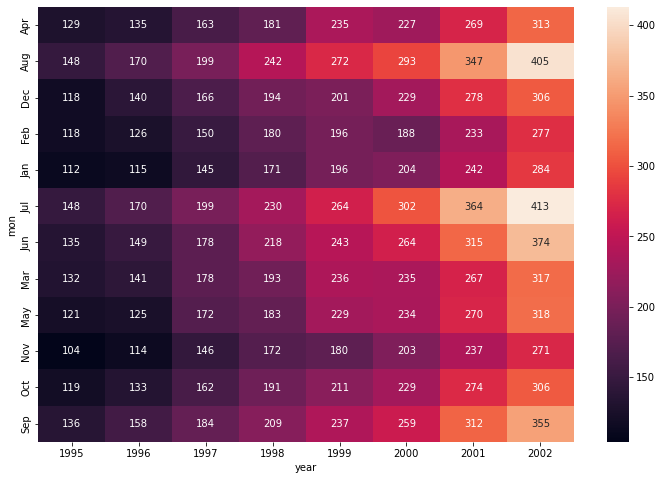

In [ ]:
pivot = pd.pivot_table(data = df,values= 'Passengers', index='mon', columns='year')
plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot= True, fmt='g')
plt.show()

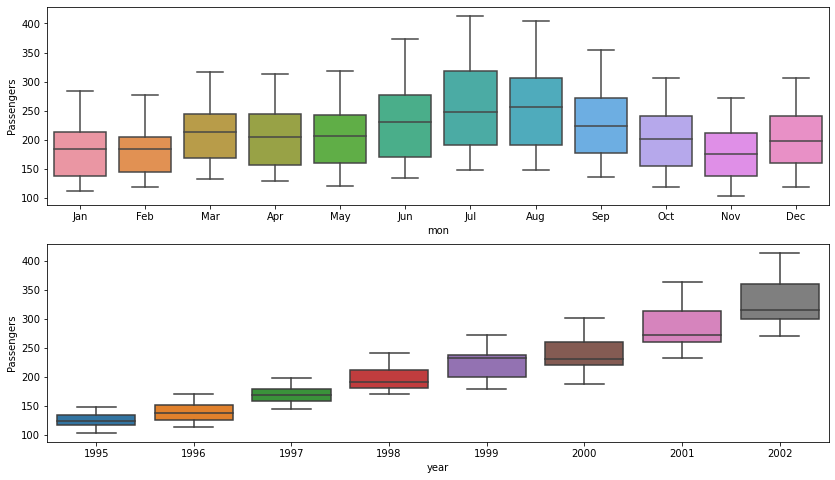

In [ ]:
fig,axs = plt.subplots(2,1,sharey= True, figsize=(14,8))
sns.boxplot(ax = axs[0], x= 'mon', y='Passengers', data=df)
sns.boxplot(ax = axs[1], x= 'year', y='Passengers', data=df)
plt.show()

#### ========================================================================================================

## 4. Model  building and evaluation matrix

In [ ]:
df1 = df.copy()

df1['t'] = range(1,97)
df1['t_sqr'] = df1['t']*df1['t']
df1['log_y'] = np.log(df1['Passengers'])
df1 = pd.get_dummies(data = df1,columns= ['mon'])

df1.head()

,Month,Passengers,year,t,t_sqr,log_y,mon_Apr,mon_Aug,mon_Dec,mon_Feb,mon_Jan,mon_Jul,mon_Jun,mon_Mar,mon_May,mon_Nov,mon_Oct,mon_Sep
0,1995-01-01,112,1995,1,1,4.718499,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,1995,2,4,4.770685,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,1995,3,9,4.882802,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,1995,4,16,4.859812,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,1995,5,25,4.795791,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
train = df1.head(75)
test = df1.tail(21)

In [ ]:
def RMSE(act,pred):
    MSE = np.mean((act-pred)**2)
    return np.sqrt(MSE)

#### ========================================================================================================

## 5. Forecasting with Model based Techniques 

### 5.1 Linear model

In [ ]:
lin_model = smf.ols('Passengers~t', data= train).fit()
lin_pred = lin_model.predict(test['t'])
RMSE_lin = RMSE(test['Passengers'],lin_pred)

### 5.2 Exponential model 

In [ ]:
expo_model = smf.ols('log_y~t', data= train).fit()
expo_pred = expo_model.predict(test['t'])
RMSE_expo = RMSE(test['Passengers'],expo_pred)

### 5.3 Quadratic model

In [ ]:
quad_model = smf.ols('Passengers ~ t + t_sqr', data= train).fit()
quad_pred = quad_model.predict(test[['t','t_sqr']])
RMSE_quad = RMSE(test['Passengers'],quad_pred)

### 5.4 Additive model

In [ ]:
addit_model = smf.ols('Passengers ~ mon_Apr+mon_Aug+mon_Dec+mon_Feb+mon_Jan+ mon_Jul+ mon_Jun+mon_Mar+mon_May+mon_Nov+mon_Oct+mon_Sep', data= train).fit()
addit_pred = addit_model.predict(test[[ 'mon_Apr','mon_Aug', 'mon_Dec', 'mon_Feb', 'mon_Jan', 'mon_Jul', 'mon_Jun','mon_Mar', 'mon_May', 'mon_Nov', 'mon_Oct','mon_Sep']])
RMSE_addit = RMSE(test['Passengers'],addit_pred)

### 5.5 Additive Quadratic model

In [ ]:
addit_quad_model = smf.ols('Passengers ~ t + t_sqr+mon_Apr+mon_Aug+mon_Dec+mon_Feb+mon_Jan+ mon_Jul+ mon_Jun+mon_Mar+mon_May+mon_Nov+mon_Oct+mon_Sep', data= train).fit()
addit_quad_pred = addit_quad_model.predict(test[[ 't','t_sqr','mon_Apr','mon_Aug', 'mon_Dec', 'mon_Feb', 'mon_Jan', 'mon_Jul', 'mon_Jun','mon_Mar', 'mon_May', 'mon_Nov', 'mon_Oct','mon_Sep']])
RMSE_addit_quad = RMSE(test['Passengers'],addit_quad_pred)

### 5.6 Multiplicative seasonality

In [ ]:
multip_model = smf.ols('log_y ~ mon_Apr+mon_Aug+mon_Dec+mon_Feb+mon_Jan+ mon_Jul+ mon_Jun+mon_Mar+mon_May+mon_Nov+mon_Oct+mon_Sep', data= train).fit()
multip_pred = multip_model.predict(test[[ 'mon_Apr','mon_Aug', 'mon_Dec', 'mon_Feb', 'mon_Jan', 'mon_Jul', 'mon_Jun','mon_Mar', 'mon_May', 'mon_Nov', 'mon_Oct','mon_Sep']])
RMSE_multip = RMSE(test['Passengers'],multip_pred)

### 5.7 Multiplicative additive seasonality

In [ ]:
add_multip_model = smf.ols('log_y ~ t+mon_Apr+mon_Aug+mon_Dec+mon_Feb+mon_Jan+ mon_Jul+ mon_Jun+mon_Mar+mon_May+mon_Nov+mon_Oct+mon_Sep', data= train).fit()
add_multip_pred = add_multip_model.predict(test[['t','mon_Apr','mon_Aug', 'mon_Dec', 'mon_Feb', 'mon_Jan', 'mon_Jul', 'mon_Jun','mon_Mar', 'mon_May', 'mon_Nov', 'mon_Oct','mon_Sep']])
RMSE_add_multip = RMSE(test['Passengers'],add_multip_pred)

### 5.8 RMSE comparison

In [ ]:
RMSE_data1 = pd.DataFrame(data={'Model': ['Linear','Exponential','Quadratic','Additive','Additive-Quadratic','Multiplicative','Multiplictive-additive'],
                              'RMSE': [RMSE_lin, RMSE_expo, RMSE_quad, RMSE_addit, RMSE_addit_quad, RMSE_multip, RMSE_add_multip]})
RMSE_data1.sort_values(by='RMSE',ascending=True)

,Model,RMSE
4,Additive-Quadratic,39.795561
0,Linear,56.023311
2,Quadratic,58.491135
3,Additive,131.178597
6,Multiplictive-additive,312.153783
1,Exponential,312.186051
5,Multiplicative,312.684037


#### =======================================================================================================

## 6. Data driven Forecasting with exponential smoothing techniques

In [ ]:
df2 = df.copy()

train = df2.head(75)
test = df2.tail(21)

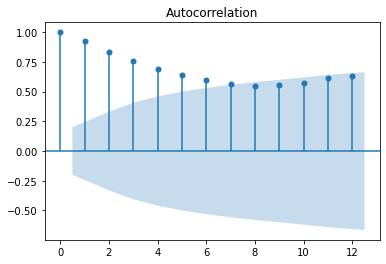

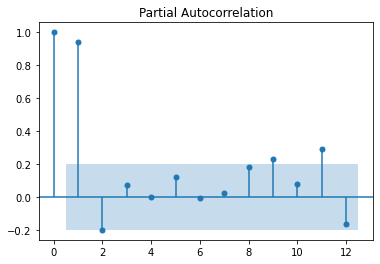

In [ ]:
plot_acf(x=df['Passengers'], ax=None, lags=12)
plot_pacf(x=df['Passengers'], ax=None, lags=12)
plt.show()

### 6.1 Seasonal decomposition

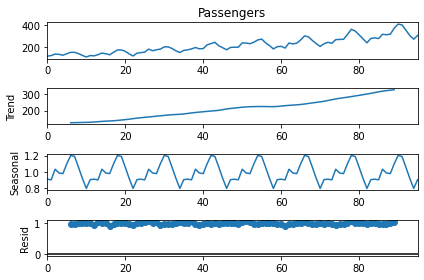

In [ ]:
sd_plot = seasonal_decompose(x= df['Passengers'], period=12,model='multiplicative')
sd_plot.plot()
plt.show()

### 6.2 Simple Exponential Method

In [ ]:
simple_expo = SimpleExpSmoothing(df2['Passengers']).fit(smoothing_level=0.9)
simple_pred = simple_expo.predict(start=test.index[0], end=test.index[-1])
RMSE_simple = RMSE(test['Passengers'], simple_pred)

### 6.3 Holts Method

In [ ]:
holts_expo = Holt(df2['Passengers']).fit(smoothing_level=0.9, smoothing_trend=0.01)
holts_pred = holts_expo.predict(start=test.index[0], end=test.index[-1])
RMSE_holts = RMSE(test['Passengers'], holts_pred)

### 6.4 Holts Winter Method with additive trend and additive seasonality

In [ ]:
holts_winter_add_add = ExponentialSmoothing(df2['Passengers'],trend='add',seasonal='add', seasonal_periods=12).fit(smoothing_trend=0.8)
holts_winter_add_add_pred = holts_winter_add_add.predict(start=test.index[0], end=test.index[-1])
RMSE_holts_winter_add_add = RMSE(test['Passengers'], holts_winter_add_add_pred)

### 6.5 Holts Winter Method with multiplicative trend and additive seasonality

In [ ]:
holts_winter_mul_add = ExponentialSmoothing(df2['Passengers'],trend='mul',seasonal='add', seasonal_periods=12).fit()
holts_winter_mul_add_pred = holts_winter_mul_add.predict(start=test.index[0], end=test.index[-1])
RMSE_holts_winter_mul_add = RMSE(test['Passengers'], holts_winter_mul_add_pred)

### 6.6 Holts Winter Method with multiplicative trend and multiplicative seasonality

In [ ]:
holts_winter_mul_mul = ExponentialSmoothing(df2['Passengers'],trend='mul',seasonal='mul', seasonal_periods=12).fit()
holts_winter_mul_mul_pred = holts_winter_mul_mul.predict(start=test.index[0], end=test.index[-1])
RMSE_holts_winter_mul_mul = RMSE(test['Passengers'], holts_winter_mul_mul_pred)

### 6.6 RMSE comparison

In [ ]:
RMSE_data2 = pd.DataFrame(data= {'Model': ['Simple exponential method','Holts method', 'Holts Winter Method with additive trend and additive seasonality','Holts Winter Method with multiplicative trend and additive seasonality','Holts Winter Method with multiplicative trend and multiplicative seasonality'],
                                'RMSE' : [RMSE_simple, RMSE_holts, RMSE_holts_winter_add_add, RMSE_holts_winter_mul_add, RMSE_holts_winter_mul_mul]})
RMSE_data2.sort_values(by='RMSE')

,Model,RMSE
4,Holts Winter Method with multiplicative trend ...,6.159684
2,Holts Winter Method with additive trend and ad...,8.963988
3,Holts Winter Method with multiplicative trend ...,10.670108
0,Simple exponential method,35.264618
1,Holts method,35.390574


#### ========================================================================================================

## 7. RMSE comparison for all

In [ ]:
RMSE_all = pd.concat([RMSE_data1,RMSE_data2])
pd.set_option('max_colwidth', 80)
RMSE_all.sort_values(by='RMSE')

,Model,RMSE
4,Holts Winter Method with multiplicative trend and multiplicative seasonality,6.159684
2,Holts Winter Method with additive trend and additive seasonality,8.963988
3,Holts Winter Method with multiplicative trend and additive seasonality,10.670108
0,Simple exponential method,35.264618
1,Holts method,35.390574
4,Additive-Quadratic,39.795561
0,Linear,56.023311
2,Quadratic,58.491135
3,Additive,131.178597
6,Multiplictive-additive,312.153783


#### ========================================================================================================

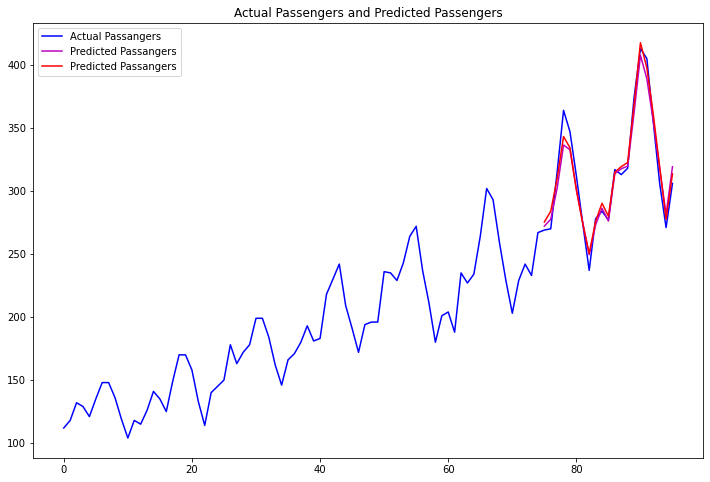

In [ ]:
# Plot of Actual values and Predicted values
plt.plot(df.Passengers, color='b', label='Actual Passangers')
plt.plot(holts_winter_mul_add_pred, color='m', label='Predicted Passangers')
plt.plot(holts_winter_add_add_pred, color='r', label='Predicted Passangers')

# Added titles and adjust dimensions
plt.title('Actual Passengers and Predicted Passengers')
plt.legend()
plt.rcParams['figure.figsize'] = (12,8) 

plt.show()